LeNet是卷积神经网络里最有名的一个网络。是80年代末Lecun提出来的。最早是手写数字的应用。应用于银行行业和邮政局行业。

知名度最高的就是MNIST的数据集。
- 50000个训练数据，10000个测试数据，图像大小28x28，10类

LeNet
- 输入是32x32的image
- convolution层: 6@28x28，通道数是6，输出是通道数是6，高宽都是28的输出，5x5的卷积核，叫做C1 feature map
- pooling层：6@14x14，S2 feature map
- convolution层：接下来又是一个卷积层，16@10x10，仍然是5x5的卷积核，通道数会增加，从6变成16了，C3 feature map
- pooling层：16@5x5，S4 feature map
- full：最后再拉成一个向量，全连接层，输出120 - F5 full
- full：全连接层，输出84 - F6 full
- Gauss：高斯层，现在也不用了，可以理解成是全连接层，就是一个softmax，10 - Out

总结
- LeNet是早期成功的神经网络
- 先使用卷积层来学习图片空间信息
- 然后使用全连接层来转换到类别空间


为什么卷积层之后要加激活函数？
1. 引入非线性
卷积操作本身是线性的，因为它涉及输入特征和卷积核权重之间的线性组合。为了使网络能够学习更复杂的模式，需要在卷积操作后应用非线性激活函数。Sigmoid 函数可以将线性输出转换为非线性输出（在0和1之间的平滑转换），这有助于进行复杂决策的建模。
2. 特征归一化
Sigmoid 函数的输出范围是 (0, 1)，这对某些需要输出归一化的情况非常有用，尤其是在网络输出需要表示概率或存在严格范围要求的场合。在隐藏层中，这可以帮助维持数据在网络深层传播时的数值稳定性。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l==0.17.6

In [1]:
import os
path = '/content/drive/MyDrive'
os.chdir(path)

!source venv_d2l/bin/activate

path = '/content/drive/MyDrive/d2l-zh'
os.chdir(path)

In [2]:
# 卷积神经网络（LeNet）
# LeNet(LeNet-5)由两个步幅组成：卷积编码器核全连接层密集块
import torch
from torch import nn
from d2l import torch as d2l

# 原来MNIST是32x32是因为两边各pad了2行2列，这边28x28就是把边缘删掉了
# 通道数为1，给输入用的
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

# 输入通道是1，输出通道是6
# 这里padding 2保证输出还是28x28
# 卷积后增加一个sigmoid的激活函数，为了引入非线性性质
# 卷积层结果是4D的东西，通过nn.Flatten()变成一维的向量 -- 第一维批量那个维度保持住，后面全部拉成一个向量

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [3]:
# 检查模型
# 卷积就是把层变小变小，但是通道数变多变多，每个通道信息就可以认为是空间的pattern，把抽出来的压缩的信息发到不同的通道里面 -- 这就是卷积神经网络的核心思想
# 现在的神经网络最后高宽会变成1，然后通道数会变到很高上千
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
# LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# 对evaluate_accuracy函数进行轻微的修改
# LeNet是唯一一个CPU能跑的网络，这里还是GPU的实现
# 如果是torch.nn实现的版本，变成eval的module
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2) # 累加器
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        # X放到network里得到输出，算一下accuracy，y.numel()是y的元素个数
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1] # 所有分类正确的个数除以y的个数得到accuracy

In [6]:
# 为了使用GPU，我们还需要一点小改动
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU"""
    def init_weights(m):
        # 如果是全连接层或卷积层，那么就用xavier uniform来初始化，根据输入输出的大小，使得你在随机输入的时候输入和输出的方差是差不多的
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # apply对net里的每个parameter都取run一下这个函数
    net.apply(init_weights)
    print('training on', device) # 常见的问题是你说在GPU上跑，结果没在GPU上跑，半天不出结果
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    # for loop对每一次数据做迭代
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        # 然后在每一次数据迭代拿一个batch出来
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad() # 梯度设0
            # 输入输出挪到GPU上
            X, y = X.to(device), y.to(device)
            # 前向操作
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 计算梯度
            l.backward()
            # 迭代
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train_acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec'
          f'on {str(device)}')

loss 0.478, train_acc 0.819, test acc 0.792
33003.2 examples/secon cuda:0


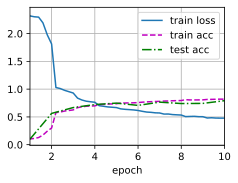

In [7]:
# 训练和评估LeNet-5模型
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

LeNet几乎没有overfitting的，但是MLP是有一点的。

训练与验证曲线之间的差距：
显著差距：如果训练和验证的损失或准确率之间的差距随着时间增大，这通常表明过拟合。训练曲线表现得很好（损失低，准确率高），而验证曲线表现相对较差。

train acc 0.820 test acc 0.799 测试低于训练，可能会有一点overfitting

高宽减半，通道数翻倍
- 通常来说，当我高宽减半的时候，我会把通道数增加到2倍。
- 增加通道数，使得我能匹配的模型和模式变多了，像素表示的信息增加了。

View对数据的构造不发生任何变化，reshape如果是按行存的话，可能做一些数据的copy出来，view不行。Reshape比view的功能更高，可能更慢，但实际使用中没区别。

数据量不大的时候，百维千维的时候，用MLP还是可以的。
当输入过大的时候，MLP基本上做不了，而且overfitting了。只能用CNN了。

深度学习第一核心是能跑得动。

16个通道是怎么取6个通道的信息的？
- 16个通道的每个通道都会对前面6个通道的卷积做一次信息的融合
- 按照组合取的，加权的

输出通道，很大程度是匹配某个局部特征。具体识别什么pattern是网络的事情。